### Abstract 

### Quora Insincere Questions Classification 

The objective is to predict whether a question asked on Quora is sincere or not.
An insincere question is defined as a question intended to make a statement rather than look for helpful answers. Some characteristics that can signify that a question is insincere:

- Has a non-neutral tone
- Has an exaggerated tone to underscore a point about a group of people
- Is rhetorical and meant to imply a statement about a group of people
- Is disparaging or inflammatory
- Suggests a discriminatory idea against a protected class of people, or seeks confirmation of a stereotype
- Makes disparaging attacks/insults against a specific person or group of people

### Tuning Hyperparameters and observing their effects on accuracy & loss
 
Using the best model from the previous part, I will now tune various different hyperparameters like Activation Function, Optimizers, Cost Function etc and observe their effects on Metrics. 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import time, gc, warnings

import re
import string
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import TweetTokenizer


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, GRU, SimpleRNN
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten, MaxPooling1D, GlobalMaxPooling1D, BatchNormalization, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras import initializers, regularizers, constraints, optimizers, layers

from wordcloud import WordCloud, STOPWORDS

np.random.seed(42)
warnings.filterwarnings("ignore")
stop_words = set(stopwords.words("english"))
punctuations = string.punctuation

%matplotlib inline

### Tokenization & Data Preprocessing

In [3]:
os.chdir(r'N:\ADVANCE DATA SCIENCE\ASSIGNMENTS\Assignment 3')
df_Quora = pd.read_csv('quora_questions_.csv')

lem = WordNetLemmatizer()
tokenizer = TweetTokenizer()

def clean_text(question):
    """
    This function receives comments and returns clean word-list
    """
    question = question.lower()
    question = re.sub("\\n", "", question)
    question = re.sub("\'", "", question)
    question = re.sub("\W+", " ", question)
    
    #Split the sentences into words
    words = tokenizer.tokenize(question)
    
    words = [lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if w not in punctuations]
    #words = [''.join(x for x in w if x.isalpha()) for w in words]

    clean_sen = " ".join(words)
    
    return clean_sen

df_Quora["question_text_"] = df_Quora["question_text"].apply(lambda question: clean_text(question))

features = df_Quora['question_text_']
target = df_Quora['target']

embed_size = 200     # how big is each word vector
max_features = 30000     # how many unique words to use (i.e num rows in embedding vector)
maxlen = 100       # max number of words in a question to use

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(features) 
X_features = tokenizer.texts_to_sequences(features)
X_features = pad_sequences(X_features, maxlen=maxlen)

Y = target

X_train, X_test, Y_train, Y_test = train_test_split(X_features, Y, test_size=0.1, stratify=Y, random_state=100)


### Part B. Activation Function 

#### I tried 4 Activation Functions - 
- RELU
- Leaky Relu
- ELU
- Sigmoid

#### 1. How does it affect the Accuracy?

Leaky Relu and RELU gave accuracy of 84.75 and 85.7 respectively. ELU gave an accuracy of only 65.34

#### 2. How does it effect how quickly the network plateaus?
The Network plateaus within first 2 epochs when using ELU, and does not plateau till 5 epochs with other activation functions. ELU will result in quick network plateau for this case as compared to Relu and Leaky Relu. 


#### Leaky rectified linear unit (Leaky ReLU)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 200)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          101760    
_________________________________________________________________
batch_normalization_1 (Batch (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                2064      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16)                0         
__________

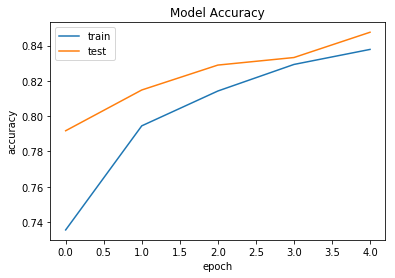

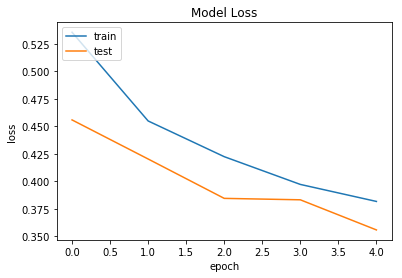

In [3]:
from keras.callbacks import ReduceLROnPlateau
from keras.layers import LeakyReLU

model_1 = Sequential()
model_1.add(Embedding(max_features, embed_size, input_length=maxlen))
model_1.add(SpatialDropout1D(0.2))
model_1.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_1.add(BatchNormalization())
model_1.add(GlobalMaxPool1D())
model_1.add(Dense(16))
model_1.add(LeakyReLU(alpha=0.05))
model_1.add(Dropout(0.3))
model_1.add(Dense(1, activation='sigmoid'))

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.SGD(lr=0.01)
model_1.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

model_1.summary()

## Train the LSTM model 
history = model_1.fit(X_train, Y_train, 
                              batch_size=128, 
                              epochs=5, 
                              validation_data=(X_test, Y_test),
                              callbacks=[rlrop])


score = model_1.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


#### Finding the best Threshold for best f1 score

9359/9359 [==============================] - 40s 4ms/step
F1 score at threshold 0.1 is 0.7327596654950915
F1 score at threshold 0.12 is 0.7430503380916604
F1 score at threshold 0.14 is 0.756207384536215
F1 score at threshold 0.16 is 0.7652886012415797
F1 score at threshold 0.18 is 0.7702884874629281
F1 score at threshold 0.2 is 0.7752407152682257
F1 score at threshold 0.22 is 0.7791153415453528
F1 score at threshold 0.24 is 0.7817273376159886
F1 score at threshold 0.26 is 0.7826970532733342
F1 score at threshold 0.28 is 0.7852091926929877
F1 score at threshold 0.3 is 0.7844311377245509
F1 score at threshold 0.32 is 0.7845943065915665
F1 score at threshold 0.34 is 0.7852722772277227
F1 score at threshold 0.36 is 0.7827997489014438
F1 score at threshold 0.38 is 0.7825810553083281
F1 score at threshold 0.4 is 0.7793381759483455
F1 score at threshold 0.42 is 0.7781234648763713
F1 score at threshold 0.44 is 0.772629131373526
F1 score at threshold 0.46 is 0.7670033670033671
F1 score at thres

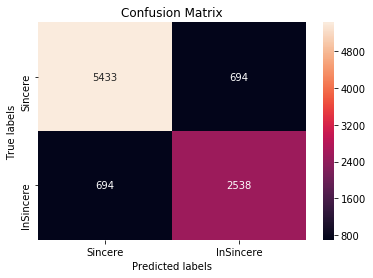

In [27]:
# Finding the best Threshold for best f1 score
Y_pred = model_1.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))
    

from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.34).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

#### Exponential linear unit (ELU)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 200)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 128)          101760    
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                2064      
_________________________________________________________________
elu_1 (ELU)                  (None, 16)                0         
__________

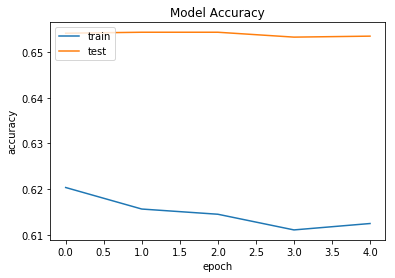

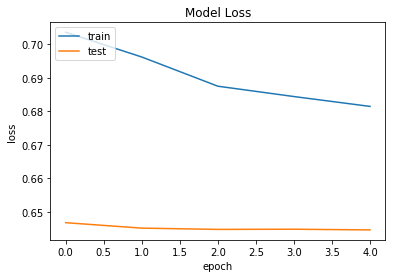

In [5]:
from keras.layers import ELU

model_2 = Sequential()
model_2.add(Embedding(max_features, embed_size, input_length=maxlen))
model_2.add(SpatialDropout1D(0.2))
model_2.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_2.add(BatchNormalization())
model_2.add(GlobalMaxPool1D())
model_2.add(Dense(16))
model_2.add(ELU(alpha=0.1))
model_2.add(Dropout(0.3))
model_2.add(Dense(1, activation='sigmoid'))

#rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.SGD(lr=0.00001)
model_2.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

model_2.summary()

## Train the LSTM model 
history = model_2.fit(X_train, Y_train, 
                              batch_size=128, 
                              epochs=5, 
                              validation_data=(X_test, Y_test))
                              #callbacks=[rlrop])


score = model_2.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


9359/9359 [==============================] - 38s 4ms/step
F1 score at threshold 0.1 is 0.5133825748550552
F1 score at threshold 0.12 is 0.5133825748550552
F1 score at threshold 0.14 is 0.5133825748550552
F1 score at threshold 0.16 is 0.5133825748550552
F1 score at threshold 0.18 is 0.5133825748550552
F1 score at threshold 0.2 is 0.5133825748550552
F1 score at threshold 0.22 is 0.5133825748550552
F1 score at threshold 0.24 is 0.5134641353562633
F1 score at threshold 0.26 is 0.513281374264355
F1 score at threshold 0.28 is 0.5128123253771852
F1 score at threshold 0.3 is 0.513128038897893
F1 score at threshold 0.32 is 0.5103762443057196
F1 score at threshold 0.34 is 0.5070729053318825
F1 score at threshold 0.36 is 0.49384993849938497
F1 score at threshold 0.38 is 0.46710208030962747
F1 score at threshold 0.4 is 0.40607323608216733
F1 score at threshold 0.42 is 0.3188246097337007
F1 score at threshold 0.44 is 0.21338075127806178
F1 score at threshold 0.46 is 0.13236814891416754
F1 score at 

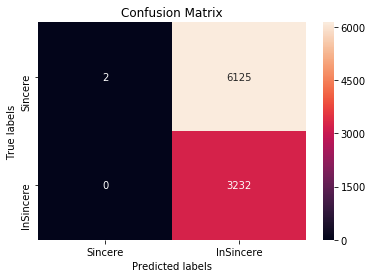

In [28]:
# Finding the best Threshold for best f1 score
Y_pred = model_2.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))
    

from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.24).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

### Part C. Cost Function

#### I tried 3 Cost Functions - 

- Binary Crossentropy
- Hinge
- Cosine Proximity

#### 1. How does it affect the Accuracy?
Binary Crossentropy gave a good accuracy of 84.36 & 0.36 loss, hinge gave a loss of 0.64 and Cosine Proximity gave a loss of -0.34 and accuracy of 34.53 

#### 2. How does it effect how quickly the network plateaus?
The Network plateaus within first 2 epochs when using Hinge and Cosine Proximity and does not plateau with other.


#### Cross-Entropy

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 100, 200)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 128)          101760    
_________________________________________________________________
batch_normalization_4 (Batch (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
__________

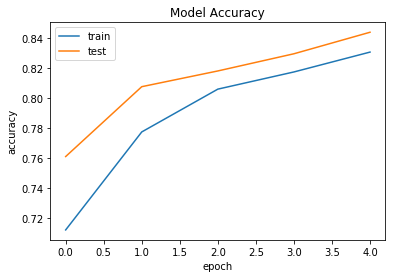

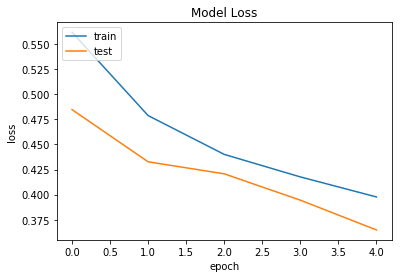

In [8]:

model_3 = Sequential()
model_3.add(Embedding(max_features, embed_size, input_length=maxlen))
model_3.add(SpatialDropout1D(0.2))
model_3.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_3.add(BatchNormalization())
model_3.add(GlobalMaxPool1D())
model_3.add(Dense(16, activation='relu'))
model_3.add(Dropout(0.3))
model_3.add(Dense(1, activation='sigmoid'))

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
opt = optimizers.SGD(lr=0.01)
model_3.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

model_3.summary()

## Train the LSTM model 
history = model_3.fit(X_train, Y_train, 
                              batch_size=128, 
                              epochs=5, 
                              validation_data=(X_test, Y_test),
                              callbacks=[rlrop])


score = model_3.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


9359/9359 [==============================] - 38s 4ms/step
F1 score at threshold 0.1 is 0.7191943127962085
F1 score at threshold 0.12 is 0.7372578057509563
F1 score at threshold 0.14 is 0.7492677957468482
F1 score at threshold 0.16 is 0.7580266249021144
F1 score at threshold 0.18 is 0.7651454496930877
F1 score at threshold 0.2 is 0.772608755317689
F1 score at threshold 0.22 is 0.7767044659106818
F1 score at threshold 0.24 is 0.7821980538065254
F1 score at threshold 0.26 is 0.7825833697393331
F1 score at threshold 0.28 is 0.781837006360006
F1 score at threshold 0.3 is 0.7818620066285026
F1 score at threshold 0.32 is 0.7799877600979191
F1 score at threshold 0.34 is 0.7782270606531881
F1 score at threshold 0.36 is 0.776425975667562
F1 score at threshold 0.38 is 0.7734274711168164
F1 score at threshold 0.4 is 0.7694313182336646
F1 score at threshold 0.42 is 0.7670369756259326
F1 score at threshold 0.44 is 0.7596559284870973
F1 score at threshold 0.46 is 0.7522715583747642
F1 score at thresh

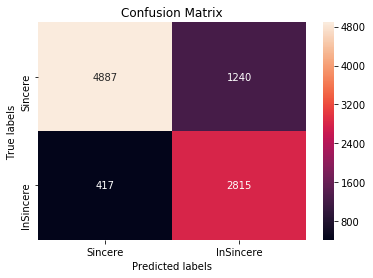

In [29]:
# Finding the best Threshold for best f1 score
Y_pred = model_3.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))
    

from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.2).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

#### Hinge Loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 100, 200)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 128)          101760    
_________________________________________________________________
batch_normalization_5 (Batch (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_5 (Dropout)          (None, 16)                0         
__________

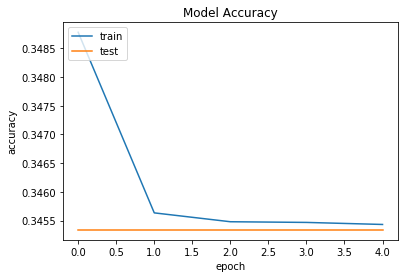

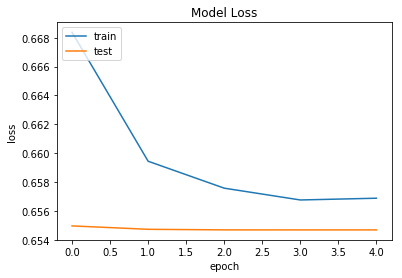

In [10]:

model_4 = Sequential()
model_4.add(Embedding(max_features, embed_size, input_length=maxlen))
model_4.add(SpatialDropout1D(0.2))
model_4.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_4.add(BatchNormalization())
model_4.add(GlobalMaxPool1D())
model_4.add(Dense(16, activation='relu'))
model_4.add(Dropout(0.3))
model_4.add(Dense(1, activation='sigmoid'))

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.SGD(lr=0.01)
model_4.compile(loss='hinge',
                  optimizer=opt,
                  metrics=['accuracy'])

model_4.summary()

## Train the LSTM model 
history = model_4.fit(X_train, Y_train, 
                              batch_size=128, 
                              epochs=5, 
                              validation_data=(X_test, Y_test),
                              callbacks=[rlrop])


score = model_4.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


9359/9359 [==============================] - 18s 2ms/step
F1 score at threshold 0.1 is 0.5133825748550552
F1 score at threshold 0.12 is 0.5133825748550552
F1 score at threshold 0.14 is 0.5133825748550552
F1 score at threshold 0.16 is 0.5133825748550552
F1 score at threshold 0.18 is 0.5133825748550552
F1 score at threshold 0.2 is 0.5133825748550552
F1 score at threshold 0.22 is 0.5133825748550552
F1 score at threshold 0.24 is 0.5133825748550552
F1 score at threshold 0.26 is 0.5133825748550552
F1 score at threshold 0.28 is 0.5133825748550552
F1 score at threshold 0.3 is 0.5133825748550552
F1 score at threshold 0.32 is 0.5133825748550552
F1 score at threshold 0.34 is 0.5133825748550552
F1 score at threshold 0.36 is 0.5133825748550552
F1 score at threshold 0.38 is 0.5133825748550552
F1 score at threshold 0.4 is 0.5133825748550552
F1 score at threshold 0.42 is 0.5133825748550552
F1 score at threshold 0.44 is 0.5133825748550552
F1 score at threshold 0.46 is 0.5133825748550552
F1 score at thr

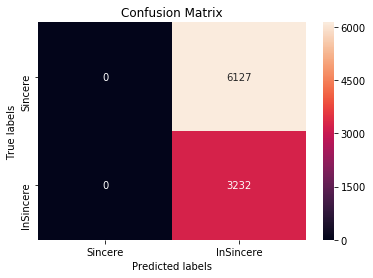

In [11]:
# Finding the best Threshold for best f1 score
Y_pred = model_4.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))
    

from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.5).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

#### Cosine Proximity

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 100, 200)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 128)          101760    
_________________________________________________________________
batch_normalization_6 (Batch (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_6 (Dropout)          (None, 16)                0         
__________

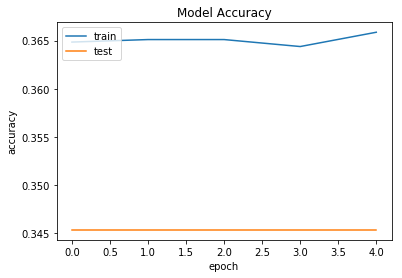

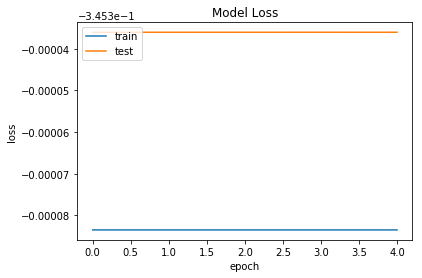

In [12]:


model_5 = Sequential()
model_5.add(Embedding(max_features, embed_size, input_length=maxlen))
model_5.add(SpatialDropout1D(0.2))
model_5.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_5.add(BatchNormalization())
model_5.add(GlobalMaxPool1D())
model_5.add(Dense(16, activation='relu'))
model_5.add(Dropout(0.3))
model_5.add(Dense(1, activation='sigmoid'))

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.SGD(lr=0.01)
model_5.compile(loss='cosine_proximity',
                  optimizer=opt,
                  metrics=['accuracy'])

model_5.summary()

## Train the LSTM model 
history = model_5.fit(X_train, Y_train, 
                              batch_size=128, 
                              epochs=5, 
                              validation_data=(X_test, Y_test),
                              callbacks=[rlrop])


score = model_5.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


9359/9359 [==============================] - 18s 2ms/step
F1 score at threshold 0.1 is 0.5133825748550552
F1 score at threshold 0.12 is 0.5133825748550552
F1 score at threshold 0.14 is 0.5133825748550552
F1 score at threshold 0.16 is 0.5133825748550552
F1 score at threshold 0.18 is 0.5133825748550552
F1 score at threshold 0.2 is 0.5133825748550552
F1 score at threshold 0.22 is 0.5133825748550552
F1 score at threshold 0.24 is 0.5133825748550552
F1 score at threshold 0.26 is 0.5133825748550552
F1 score at threshold 0.28 is 0.5133825748550552
F1 score at threshold 0.3 is 0.5133825748550552
F1 score at threshold 0.32 is 0.5133825748550552
F1 score at threshold 0.34 is 0.5133825748550552
F1 score at threshold 0.36 is 0.5133825748550552
F1 score at threshold 0.38 is 0.5133825748550552
F1 score at threshold 0.4 is 0.5133825748550552
F1 score at threshold 0.42 is 0.5133825748550552
F1 score at threshold 0.44 is 0.5133825748550552
F1 score at threshold 0.46 is 0.5133825748550552
F1 score at thr

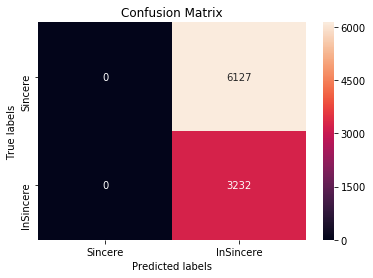

In [13]:
# Finding the best Threshold for best f1 score
Y_pred = model_5.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))
    

from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.4).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

### Part D. Epochs

#### I tried 3 different Epoch value - 
- 5 epoch
- 7 epoch
- 10 epoch

#### 1. How does it affect the Accuracy?

Accuracy seems to increase with the number of epochs upto a certain level. After that network plateaus or it stops learning anything new. 
7 Epochs gave an accuracy of 84.56 and 10 Epochs an accuracy of 85.07. 

#### 2. How does it effect how quickly the network plateaus?
The Network plateaus in 8 epochs in case of 10 epochs. 


#### Epoch - 7

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 100, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 100, 200)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100, 128)          101760    
_________________________________________________________________
batch_normalization_7 (Batch (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 128)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_7 (Dropout)          (None, 16)                0         
__________

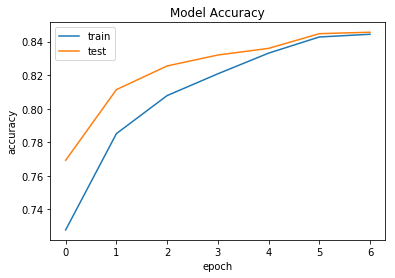

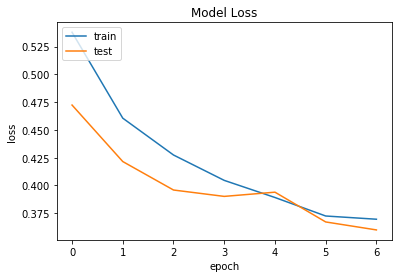

In [14]:


model_6 = Sequential()
model_6.add(Embedding(max_features, embed_size, input_length=maxlen))
model_6.add(SpatialDropout1D(0.2))
model_6.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_6.add(BatchNormalization())
model_6.add(GlobalMaxPool1D())
model_6.add(Dense(16, activation='relu'))
model_6.add(Dropout(0.3))
model_6.add(Dense(1, activation='sigmoid'))

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.SGD(lr=0.01)
model_6.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

model_6.summary()

## Train the LSTM model 
history = model_6.fit(X_train, Y_train, 
                              batch_size=128, 
                              epochs=7, 
                              validation_data=(X_test, Y_test),
                              callbacks=[rlrop])


score = model_6.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


9359/9359 [==============================] - 39s 4ms/step
F1 score at threshold 0.1 is 0.7422807233362038
F1 score at threshold 0.12 is 0.7554823171504627
F1 score at threshold 0.14 is 0.7628571428571428
F1 score at threshold 0.16 is 0.7722666666666668
F1 score at threshold 0.18 is 0.7769136307818256
F1 score at threshold 0.2 is 0.7818941504178272
F1 score at threshold 0.22 is 0.7850970392406857
F1 score at threshold 0.24 is 0.7845510880530335
F1 score at threshold 0.26 is 0.7841358115030002
F1 score at threshold 0.28 is 0.78359096313912
F1 score at threshold 0.3 is 0.7871570696412421
F1 score at threshold 0.32 is 0.7882209337808972
F1 score at threshold 0.34 is 0.78644382544104
F1 score at threshold 0.36 is 0.7858601728201101
F1 score at threshold 0.38 is 0.7816385081287853
F1 score at threshold 0.4 is 0.7777597665748096
F1 score at threshold 0.42 is 0.7691801119525847
F1 score at threshold 0.44 is 0.7657371848388713
F1 score at threshold 0.46 is 0.7607590647238225
F1 score at thresho

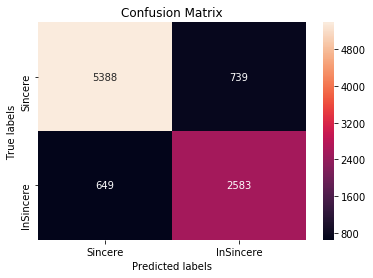

In [30]:
# Finding the best Threshold for best f1 score
Y_pred = model_6.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))
    

from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.32).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

#### Epoch - 10

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 100, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 100, 200)          0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 100, 128)          101760    
_________________________________________________________________
batch_normalization_8 (Batch (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 128)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0         
__________

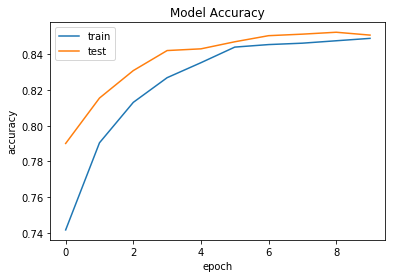

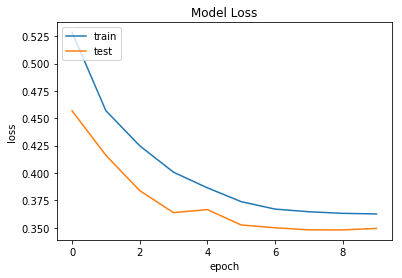

In [16]:


model_7 = Sequential()
model_7.add(Embedding(max_features, embed_size, input_length=maxlen))
model_7.add(SpatialDropout1D(0.2))
model_7.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_7.add(BatchNormalization())
model_7.add(GlobalMaxPool1D())
model_7.add(Dense(16, activation='relu'))
model_7.add(Dropout(0.3))
model_7.add(Dense(1, activation='sigmoid'))

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.SGD(lr=0.01)
model_7.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

model_7.summary()

## Train the LSTM model 
history = model_7.fit(X_train, Y_train, 
                              batch_size=128, 
                              epochs=10, 
                              validation_data=(X_test, Y_test),
                              callbacks=[rlrop])


score = model_7.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


9359/9359 [==============================] - 40s 4ms/step
F1 score at threshold 0.1 is 0.7295476419634264
F1 score at threshold 0.12 is 0.7434593924364538
F1 score at threshold 0.14 is 0.7542900724545569
F1 score at threshold 0.16 is 0.760976877110938
F1 score at threshold 0.18 is 0.7679045092838195
F1 score at threshold 0.2 is 0.7731819410651528
F1 score at threshold 0.22 is 0.77692095841366
F1 score at threshold 0.24 is 0.7819633104607198
F1 score at threshold 0.26 is 0.7861321158510486
F1 score at threshold 0.28 is 0.7913522925130585
F1 score at threshold 0.3 is 0.7914580265095729
F1 score at threshold 0.32 is 0.7940029985007496
F1 score at threshold 0.34 is 0.79342865835108
F1 score at threshold 0.36 is 0.7904320987654322
F1 score at threshold 0.38 is 0.7883713660518913
F1 score at threshold 0.4 is 0.7876679841897233
F1 score at threshold 0.42 is 0.786365818530965
F1 score at threshold 0.44 is 0.7793305167370815
F1 score at threshold 0.46 is 0.774831164552792
F1 score at threshold 

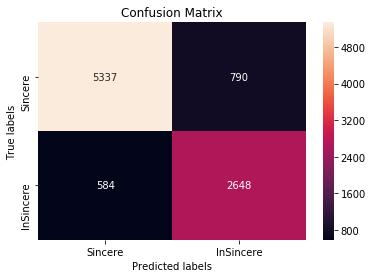

In [31]:
# Finding the best Threshold for best f1 score
Y_pred = model_7.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))
    

from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.32).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

### Part E. Gradient Estimation

#### I tried 3 Activation Functions - 
- Adam
- SGD
- Adadelta

#### 1. How does it affect the Accuracy?

Adam and SGD gave an accuracy of 89.09% and 83.13% resp & 34.53% for Adadelta

#### 2. How does it effect how quickly the network plateaus?
The Network plateaus within first 2 epochs when using Adadelta, and does not plateau till 5 epochs with other Estimation 


#### Adam

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 100, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 100, 200)          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 100, 128)          101760    
_________________________________________________________________
batch_normalization_9 (Batch (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_9 (Dropout)          (None, 16)                0         
__________

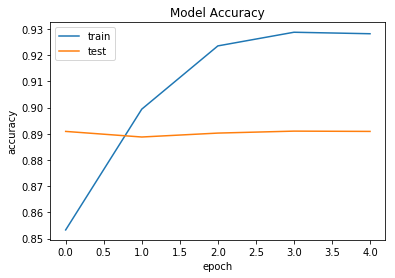

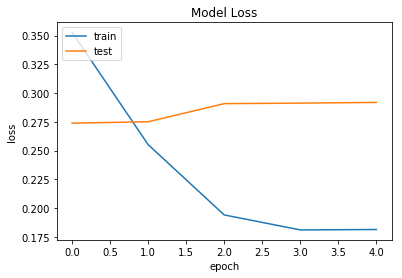

In [18]:


model_8 = Sequential()
model_8.add(Embedding(max_features, embed_size, input_length=maxlen))
model_8.add(SpatialDropout1D(0.2))
model_8.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_8.add(BatchNormalization())
model_8.add(GlobalMaxPool1D())
model_8.add(Dense(16, activation='relu'))
model_8.add(Dropout(0.3))
model_8.add(Dense(1, activation='sigmoid'))

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.Adam()
model_8.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

model_8.summary()

## Train the LSTM model 
history = model_8.fit(X_train, Y_train, 
                              batch_size=128, 
                              epochs=5, 
                              validation_data=(X_test, Y_test),
                              callbacks=[rlrop])


score = model_8.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


9359/9359 [==============================] - 41s 4ms/step
F1 score at threshold 0.1 is 0.823673803354698
F1 score at threshold 0.12 is 0.8293355390129582
F1 score at threshold 0.14 is 0.8330781010719756
F1 score at threshold 0.16 is 0.8356452290878521
F1 score at threshold 0.18 is 0.8373340864162666
F1 score at threshold 0.2 is 0.8399203866932045
F1 score at threshold 0.22 is 0.8409904107628453
F1 score at threshold 0.24 is 0.8419991358202507
F1 score at threshold 0.26 is 0.8425778421433743
F1 score at threshold 0.28 is 0.8441142191142191
F1 score at threshold 0.3 is 0.8439373994442007
F1 score at threshold 0.32 is 0.8441634813290209
F1 score at threshold 0.34 is 0.8445167011528228
F1 score at threshold 0.36 is 0.8460739201424966
F1 score at threshold 0.38 is 0.845763723150358
F1 score at threshold 0.4 is 0.8447913539477634
F1 score at threshold 0.42 is 0.8449811320754718
F1 score at threshold 0.44 is 0.8434980988593156
F1 score at threshold 0.46 is 0.8433624253559946
F1 score at thres

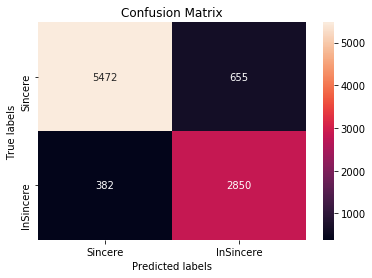

In [32]:
# Finding the best Threshold for best f1 score
Y_pred = model_8.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))
    

from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.36).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

#### SGD 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 100, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 100, 200)          0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 100, 128)          101760    
_________________________________________________________________
batch_normalization_10 (Batc (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 128)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
__________

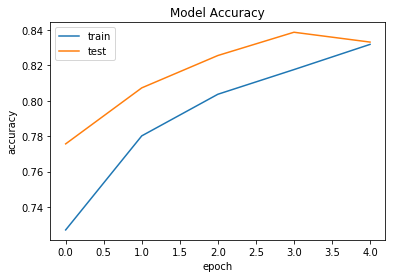

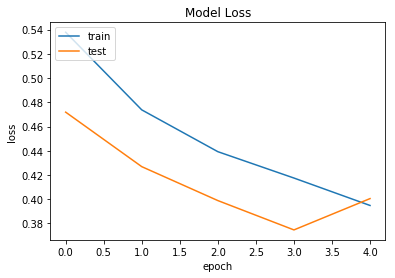

In [20]:


model_9 = Sequential()
model_9.add(Embedding(max_features, embed_size, input_length=maxlen))
model_9.add(SpatialDropout1D(0.2))
model_9.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_9.add(BatchNormalization())
model_9.add(GlobalMaxPool1D())
model_9.add(Dense(16, activation='relu'))
model_9.add(Dropout(0.3))
model_9.add(Dense(1, activation='sigmoid'))

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.SGD(lr=0.01)
model_9.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

model_9.summary()

## Train the LSTM model 
history = model_9.fit(X_train, Y_train, 
                              batch_size=128, 
                              epochs=5, 
                              validation_data=(X_test, Y_test),
                              callbacks=[rlrop])


score = model_9.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


9359/9359 [==============================] - 40s 4ms/step
F1 score at threshold 0.1 is 0.7625364818254178
F1 score at threshold 0.12 is 0.7702150830383884
F1 score at threshold 0.14 is 0.7746341463414634
F1 score at threshold 0.16 is 0.7785846504342874
F1 score at threshold 0.18 is 0.7811682650392328
F1 score at threshold 0.2 is 0.7829170976799172
F1 score at threshold 0.22 is 0.78154030566377
F1 score at threshold 0.24 is 0.7792956891317547
F1 score at threshold 0.26 is 0.7780341485925242
F1 score at threshold 0.28 is 0.776735459662289
F1 score at threshold 0.3 is 0.7722740940022156
F1 score at threshold 0.32 is 0.7695268644747394
F1 score at threshold 0.34 is 0.7674001629991849
F1 score at threshold 0.36 is 0.7659574468085106
F1 score at threshold 0.38 is 0.7606338615512928
F1 score at threshold 0.4 is 0.7540097923349652
F1 score at threshold 0.42 is 0.7504273504273504
F1 score at threshold 0.44 is 0.743718592964824
F1 score at threshold 0.46 is 0.736731107205624
F1 score at threshol

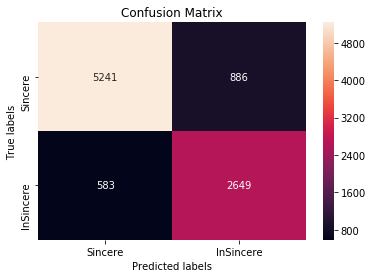

In [33]:
# Finding the best Threshold for best f1 score
Y_pred = model_9.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))
    

from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.2).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

#### Adadelta

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 100, 200)          0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 100, 128)          101760    
_________________________________________________________________
batch_normalization_11 (Batc (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_11 (Dropout)         (None, 16)                0         
__________

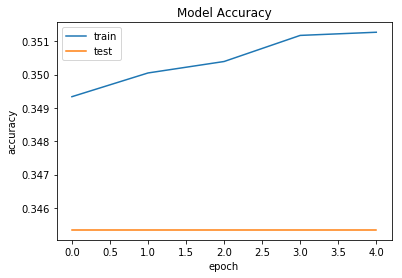

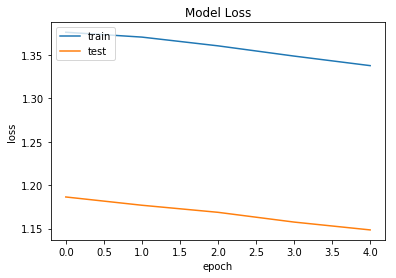

In [22]:


model_10 = Sequential()
model_10.add(Embedding(max_features, embed_size, input_length=maxlen))
model_10.add(SpatialDropout1D(0.2))
model_10.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_10.add(BatchNormalization())
model_10.add(GlobalMaxPool1D())
model_10.add(Dense(16, activation='relu'))
model_10.add(Dropout(0.3))
model_10.add(Dense(1, activation='sigmoid'))

#rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.Adadelta(lr=0.00001)
model_10.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

model_10.summary()

## Train the LSTM model 
history = model_10.fit(X_train, Y_train, 
                              batch_size=128, 
                              epochs=5, 
                              validation_data=(X_test, Y_test))
                              #callbacks=[rlrop])


score = model_10.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


9359/9359 [==============================] - 23s 2ms/step
F1 score at threshold 0.1 is 0.5133825748550552
F1 score at threshold 0.12 is 0.5133825748550552
F1 score at threshold 0.14 is 0.5133825748550552
F1 score at threshold 0.16 is 0.5133825748550552
F1 score at threshold 0.18 is 0.5133825748550552
F1 score at threshold 0.2 is 0.5133825748550552
F1 score at threshold 0.22 is 0.5133825748550552
F1 score at threshold 0.24 is 0.5133825748550552
F1 score at threshold 0.26 is 0.5133825748550552
F1 score at threshold 0.28 is 0.5133825748550552
F1 score at threshold 0.3 is 0.5133825748550552
F1 score at threshold 0.32 is 0.5133825748550552
F1 score at threshold 0.34 is 0.5133825748550552
F1 score at threshold 0.36 is 0.5133825748550552
F1 score at threshold 0.38 is 0.5133825748550552
F1 score at threshold 0.4 is 0.5133825748550552
F1 score at threshold 0.42 is 0.5133825748550552
F1 score at threshold 0.44 is 0.5133825748550552
F1 score at threshold 0.46 is 0.5133825748550552
F1 score at thr

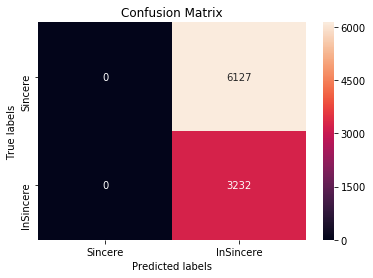

In [23]:
# Finding the best Threshold for best f1 score
Y_pred = model_10.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))
    

from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.4).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

### Part F. Network Architecture 

#### I tried all 4 Network Architecture components - 
- Pretrained
- No of layers
- Size of layer
- Different Network Arc forms(LSTM, GRU, Bidirectional GRU)

#### 1. How does it affect the Accuracy?

Accuracy increases with the complexity of the network to some extent than it does not improve(size of layer, no of layers). Accuracy was 97.65% when used with Pretrained components(Wiki Fast Text Embeddings) and 84.20% without it. So pretrained component which is trained on a large dataset is better than creating your own Embeddings from scratch when the type of text data is generic. If it is domain specific, training your own embedding would be better. 

#### 2. How does it effect how quickly the network plateaus?
The network did not plateau using these parameters, it was gradually training. But with the use of pretrained components, the model trains faster and will quickly reach its maximum level and plateau within few more epochs. 

#### Pretrained Components

In [34]:
EMBEDDING_FILE = 'wiki-news-300d-1M.vec'

def get_coefs(word,*arr):
    return word, np.asarray(arr, dtype='float32')

embeddings_index = dict(get_coefs(*o.split(" ")) 
                        for o in open(EMBEDDING_FILE, encoding="utf-8") if len(o)>100)

all_embs = np.stack(embeddings_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
embed_size = all_embs.shape[1]

word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

for word, i in word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 300)          9000000   
_________________________________________________________________
spatial_dropout1d_13 (Spatia (None, 100, 300)          0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 100, 128)          140160    
_________________________________________________________________
batch_normalization_13 (Batc (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 16)                2064      
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0         
__________

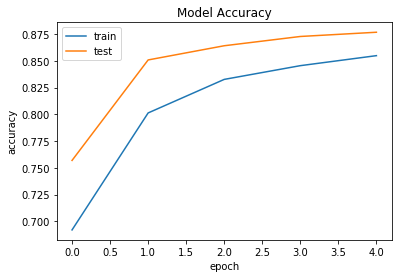

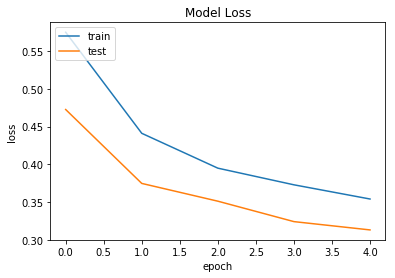

In [35]:
## Wiki Fast text Pre Trained Embeddings 

model_11 = Sequential()
model_11.add(Embedding(max_features, embed_size, input_length=maxlen, weights=[embedding_matrix]))
model_11.add(SpatialDropout1D(0.2))
model_11.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_11.add(BatchNormalization())
model_11.add(GlobalMaxPool1D())
model_11.add(Dense(16, activation='relu'))
model_11.add(Dropout(0.3))
model_11.add(Dense(1, activation='sigmoid'))

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.SGD(lr=0.01)
model_11.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

model_11.summary()

## Train the LSTM model 
history = model_11.fit(X_train, Y_train, 
                              batch_size=128, 
                              epochs=5, 
                              validation_data=(X_test, Y_test),
                              callbacks=[rlrop])


score = model_11.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


9359/9359 [==============================] - 85s 9ms/step
F1 score at threshold 0.1 is 0.792099792099792
F1 score at threshold 0.12 is 0.8013762074897446
F1 score at threshold 0.14 is 0.8097285675893577
F1 score at threshold 0.16 is 0.8134114760801417
F1 score at threshold 0.18 is 0.8192870958828405
F1 score at threshold 0.2 is 0.8215628917676557
F1 score at threshold 0.22 is 0.8241092803830447
F1 score at threshold 0.24 is 0.8283804919664439
F1 score at threshold 0.26 is 0.8283870967741934
F1 score at threshold 0.28 is 0.8293387236500146
F1 score at threshold 0.3 is 0.8315130333478956
F1 score at threshold 0.32 is 0.8314507848026991
F1 score at threshold 0.34 is 0.8334317779090373
F1 score at threshold 0.36 is 0.831845238095238
F1 score at threshold 0.38 is 0.8308293269230768
F1 score at threshold 0.4 is 0.8306573765525599
F1 score at threshold 0.42 is 0.8296703296703297
F1 score at threshold 0.44 is 0.8273215656178051
F1 score at threshold 0.46 is 0.8255634455078728
F1 score at thres

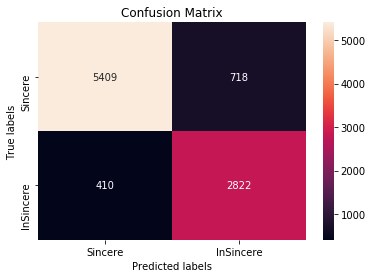

In [40]:
# Finding the best Threshold for best f1 score
Y_pred = model_11.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))
    

from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.34).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

#### Number of Layers

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 100, 300)          9000000   
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 100, 300)          0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 100, 64)           63936     
_________________________________________________________________
batch_normalization_14 (Batc (None, 100, 64)           256       
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 100, 64)           18624     
_________________________________________________________________
global_max_pooling1d_14 (Glo (None, 64)                0         
_________________________________________________________________
dense_27 (Dense)             (None, 16)                1040      
__________

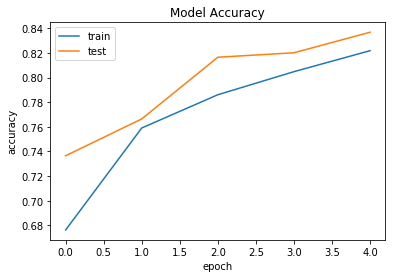

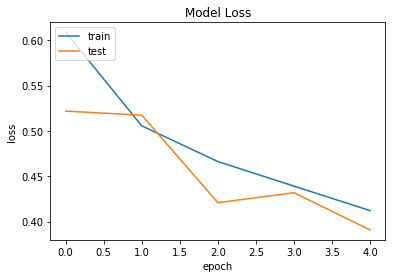

In [37]:

model_12 = Sequential()
model_12.add(Embedding(max_features, embed_size, input_length=maxlen))
model_12.add(SpatialDropout1D(0.2))
model_12.add(Bidirectional(GRU(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_12.add(BatchNormalization())
model_12.add(Bidirectional(GRU(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_12.add(GlobalMaxPool1D())
model_12.add(Dense(16, activation='relu'))
model_12.add(Dropout(0.3))
model_12.add(Dense(1, activation='sigmoid'))

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.SGD(lr=0.01)
model_12.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

model_12.summary()

## Train the LSTM model 
history = model_12.fit(X_train, Y_train, 
                              batch_size=128, 
                              epochs=5, 
                              validation_data=(X_test, Y_test),
                              callbacks=[rlrop])


score = model_12.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


9359/9359 [==============================] - 72s 8ms/step
F1 score at threshold 0.1 is 0.7109888795886644
F1 score at threshold 0.12 is 0.7233304423243712
F1 score at threshold 0.14 is 0.7287531806615776
F1 score at threshold 0.16 is 0.7375146694484288
F1 score at threshold 0.18 is 0.7457219251336898
F1 score at threshold 0.2 is 0.7517420412624676
F1 score at threshold 0.22 is 0.7530950062595632
F1 score at threshold 0.24 is 0.7558831868443435
F1 score at threshold 0.26 is 0.7584415584415585
F1 score at threshold 0.28 is 0.7598355842630652
F1 score at threshold 0.3 is 0.759773202029245
F1 score at threshold 0.32 is 0.7604182451886649
F1 score at threshold 0.34 is 0.7593730792870313
F1 score at threshold 0.36 is 0.7601809954751131
F1 score at threshold 0.38 is 0.7609725292074518
F1 score at threshold 0.4 is 0.7566789313709807
F1 score at threshold 0.42 is 0.7559591373439274
F1 score at threshold 0.44 is 0.7515589104036758
F1 score at threshold 0.46 is 0.7469238443631525
F1 score at thre

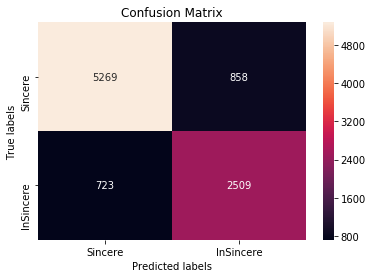

In [41]:
# Finding the best Threshold for best f1 score
Y_pred = model_12.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))
    

from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.32).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

#### Various Forms of Network Architecture

Already Implemented in Previous Notebook

- LSTM(Long Short term memory)
- GRU(Gated Recurrent Network)
- Conv1D
- Bidirectional GRU

#### Size of Each layer

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 100, 200)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 100, 64)           44736     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100, 64)           256       
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
__________

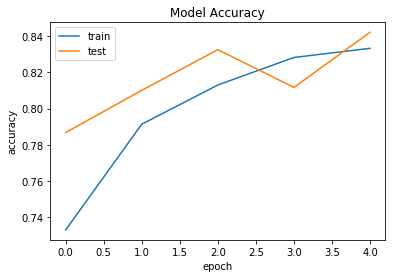

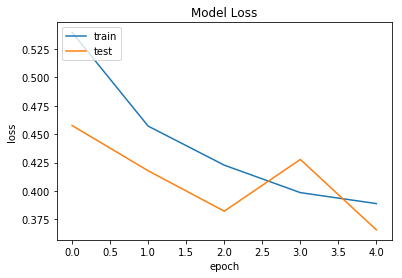

In [5]:
from keras.callbacks import ReduceLROnPlateau

model_13 = Sequential()
model_13.add(Embedding(max_features, embed_size, input_length=maxlen))
model_13.add(SpatialDropout1D(0.2))
model_13.add(Bidirectional(GRU(32, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)))
model_13.add(BatchNormalization())
model_13.add(GlobalMaxPool1D())
model_13.add(Dense(32, activation='relu'))
model_13.add(Dropout(0.3))
model_13.add(Dense(1, activation='sigmoid'))

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.SGD(lr=0.01)
model_13.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

model_13.summary()

## Train the LSTM model 
history = model_13.fit(X_train, Y_train, 
                              batch_size=128, 
                              epochs=5, 
                              validation_data=(X_test, Y_test),
                              callbacks=[rlrop])


score = model_13.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


9359/9359 [==============================] - 8s 877us/step
F1 score at threshold 0.1 is 0.7191464137522229
F1 score at threshold 0.12 is 0.7334644701253996
F1 score at threshold 0.14 is 0.7451278157428499
F1 score at threshold 0.16 is 0.7539021852237252
F1 score at threshold 0.18 is 0.7615241140420996
F1 score at threshold 0.2 is 0.7673847832015271
F1 score at threshold 0.22 is 0.7709404083900542
F1 score at threshold 0.24 is 0.7746498797566841
F1 score at threshold 0.26 is 0.7747877392430566
F1 score at threshold 0.28 is 0.777224824355972
F1 score at threshold 0.3 is 0.7780585699420246
F1 score at threshold 0.32 is 0.7794561933534744
F1 score at threshold 0.34 is 0.7758726270667482
F1 score at threshold 0.36 is 0.7724309220738901
F1 score at threshold 0.38 is 0.7696912413358539
F1 score at threshold 0.4 is 0.7680766161213088
F1 score at threshold 0.42 is 0.7662674004532212
F1 score at threshold 0.44 is 0.7625143607418348
F1 score at threshold 0.46 is 0.7570715474209652
F1 score at thr

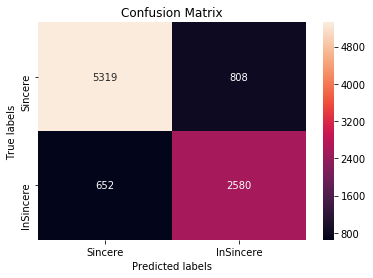

In [7]:
# Finding the best Threshold for best f1 score
Y_pred = model_13.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))
    

from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.32).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

### Part G. Network Initialization

#### I tried 2 different Network Initialization-
- Uniform
- Xavier Uniform

#### 1. How does it affect the Accuracy?
Xavier Uniform also called Glorot Uniform gave an accuracy of 84.53% vs Uniform which gave an accuracy of 83.05. Different types of layers  has different default Initializers.  

#### 2. How does it effect how quickly the network plateaus?
Xavier Uniform will eventually plateau quickly than Uniform if we train it for more epochs.


#### Uniform

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 100, 200)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 100, 128)          101760    
_________________________________________________________________
batch_normalization_3 (Batch (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
__________

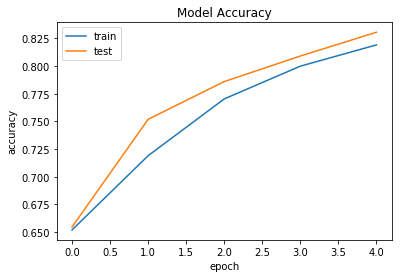

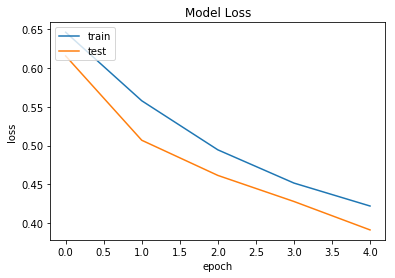

In [8]:

model_14 = Sequential()
model_14.add(Embedding(max_features, embed_size, input_length=maxlen))
model_14.add(SpatialDropout1D(0.2))
model_14.add(Bidirectional(GRU(64, return_sequences=True, dropout=0.2, recurrent_dropout=0.2, kernel_initializer="uniform", recurrent_initializer="uniform")))
model_14.add(BatchNormalization())
model_14.add(GlobalMaxPool1D())
model_14.add(Dense(16, activation='relu', kernel_initializer='uniform'))
model_14.add(Dropout(0.3))
model_14.add(Dense(1, activation='sigmoid'))

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.SGD(lr=0.01)
model_14.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

model_14.summary()

## Train the LSTM model 
history = model_14.fit(X_train, Y_train, 
                              batch_size=128, 
                              epochs=5, 
                              validation_data=(X_test, Y_test),
                              callbacks=[rlrop])


score = model_14.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


9359/9359 [==============================] - 10s 1ms/step
F1 score at threshold 0.1 is 0.6796203238414293
F1 score at threshold 0.12 is 0.7048541396008031
F1 score at threshold 0.14 is 0.720541205412054
F1 score at threshold 0.16 is 0.7338276655586806
F1 score at threshold 0.18 is 0.7431896323723883
F1 score at threshold 0.2 is 0.7514970059880239
F1 score at threshold 0.22 is 0.7532176832680471
F1 score at threshold 0.24 is 0.7551605504587157
F1 score at threshold 0.26 is 0.756875365710942
F1 score at threshold 0.28 is 0.7593089067619898
F1 score at threshold 0.3 is 0.7578787878787877
F1 score at threshold 0.32 is 0.758376882877344
F1 score at threshold 0.34 is 0.7578222778473092
F1 score at threshold 0.36 is 0.7579648121730861
F1 score at threshold 0.38 is 0.7553054662379421
F1 score at threshold 0.4 is 0.7519973911625633
F1 score at threshold 0.42 is 0.7495036399735273
F1 score at threshold 0.44 is 0.7443495730788549
F1 score at threshold 0.46 is 0.7368242094525671
F1 score at thresh

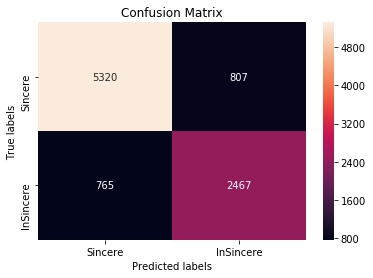

In [12]:
# Finding the best Threshold for best f1 score
Y_pred = model_14.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))
    

from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.32).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

#### Xavier Uniform

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 100, 200)          6000000   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 100, 200)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 100, 128)          101760    
_________________________________________________________________
batch_normalization_4 (Batch (None, 100, 128)          512       
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 16)                2064      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16)                0         
__________

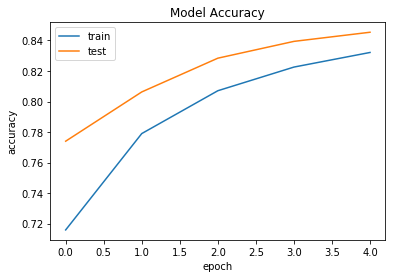

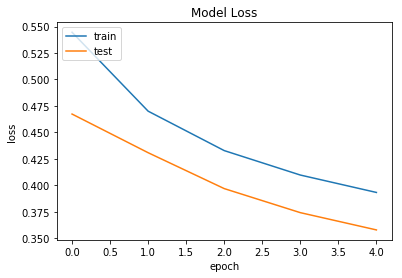

In [10]:


model_15 = Sequential()
model_15.add(Embedding(max_features, embed_size, input_length=maxlen))
model_15.add(SpatialDropout1D(0.2))
model_15.add(Bidirectional(GRU(64, return_sequences=True, kernel_initializer="glorot_uniform", recurrent_initializer="glorot_uniform", dropout=0.2, recurrent_dropout=0.2)))
model_15.add(BatchNormalization())
model_15.add(GlobalMaxPool1D())
model_15.add(Dense(16, activation='relu', kernel_initializer='glorot_uniform'))
model_15.add(Dropout(0.3))
model_15.add(Dense(1, activation='sigmoid'))

rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)
opt = optimizers.SGD(lr=0.01)
model_15.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])

model_15.summary()

## Train the LSTM model 
history = model_15.fit(X_train, Y_train, 
                              batch_size=128, 
                              epochs=5, 
                              validation_data=(X_test, Y_test),
                              callbacks=[rlrop])


score = model_15.evaluate(X_test, Y_test)
print('Test Loss: ', score[0])
print('Test Accuracy', score[1])


# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


9359/9359 [==============================] - 10s 1ms/step
F1 score at threshold 0.1 is 0.6963280018022078
F1 score at threshold 0.12 is 0.7090339788936565
F1 score at threshold 0.14 is 0.7203046893596763
F1 score at threshold 0.16 is 0.7308255984367367
F1 score at threshold 0.18 is 0.7389788293897882
F1 score at threshold 0.2 is 0.7493007882023899
F1 score at threshold 0.22 is 0.7534583063994829
F1 score at threshold 0.24 is 0.7601369141653503
F1 score at threshold 0.26 is 0.7639576917927433
F1 score at threshold 0.28 is 0.7679978266775332
F1 score at threshold 0.3 is 0.7701863354037267
F1 score at threshold 0.32 is 0.7718806889791346
F1 score at threshold 0.34 is 0.7731665719158612
F1 score at threshold 0.36 is 0.7739243056554901
F1 score at threshold 0.38 is 0.7762463343108504
F1 score at threshold 0.4 is 0.775223880597015
F1 score at threshold 0.42 is 0.7780473013947846
F1 score at threshold 0.44 is 0.7772979642196175
F1 score at threshold 0.46 is 0.7743348982785603
F1 score at thre

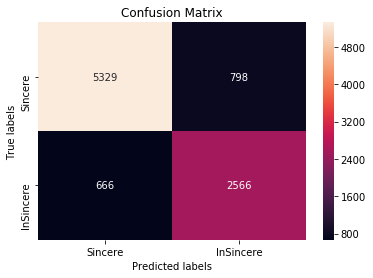

In [13]:
# Finding the best Threshold for best f1 score
Y_pred = model_15.predict([X_test], batch_size=128, verbose=1)
for thresh in np.arange(0.1, 0.701, 0.02):
    thresh = np.round(thresh, 2)
    print("F1 score at threshold {0} is {1}".format(thresh, metrics.f1_score(Y_test, (Y_pred>thresh).astype(int))))
    

from sklearn.metrics import confusion_matrix
ax= plt.subplot()
sns.heatmap(confusion_matrix(Y_test, (Y_pred>0.42).astype(int)), annot=True, ax = ax, fmt='g')
# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels([ 'Sincere', 'InSincere']); 
ax.yaxis.set_ticklabels(['Sincere', 'InSincere']);

### Conclusion

In the first part, I have trained 4 different Deep Learning network architectures for this problem. Then I used the best model, Bidirectional GRU for further parts. In the next parts, I tried 2-4 different values for each hyperparameters like Activation Function, Cost Functions, Optimizer, Epochs etc and observed how changing these values have effects on models accuracy and how quickly the network plateaus. 

The best model was Bidirectional GRU along with Pretrained Work Embeddings(Wiki Fast Text) which gave an accuracy of 90.06% and a f1 score of 86% for a threshold of 0.46. 
The individual effects of these hyperparameters are explained along with each case. 

### Contribution

Code written

- By own: 70%
- By External links used as a reference: 30%

### Citations 


EDA - https://www.kaggle.com/tunguz/just-some-simple-eda

Batch Normalization - https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/
    
Learning Rate & Plateau - https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/

Momentum - https://machinelearningmastery.com/learning-rate-for-deep-learning-neural-networks/
    
Weight Initialization - https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79

### License
MIT License

Copyright (c) 2020 Nikhil Kohli

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.